In [255]:
import pandas as pd
import ast

df = pd.read_csv("data/small.csv")
doi_list = df['doi'].to_list()

In [256]:
def get_name(doi):
    # print(df.loc[df['doi'] == doi].title.values[0])
    return df.loc[df['doi'] == doi].title.values[0]

graph = {
    "nodes": [{ "id": doi, "name": get_name(doi)} for doi in doi_list],
    "links": []
}

In [257]:
# loop through df
for index, row in df.iterrows():
    # print(row.references)
    # print(ast.literal_eval(row.references))
    references = ast.literal_eval(row.references)
    for ref in references:
        if(ref in doi_list):
            graph["links"].append({"source": row.doi, "target": ref})

100%|██████████| 10000/10000 [00:34<00:00, 288.12it/s]


BarnesHut Approximation  took  6.03  seconds
Repulsion forces  took  25.62  seconds
Gravitational forces  took  0.38  seconds
Attraction forces  took  0.13  seconds
AdjustSpeedAndApplyForces step  took  1.73  seconds
[800, 587.8048780487804, 581.9512195121952, 406.3414634146342, 400.4878048780488, 371.2195121951219, 265.8536585365854, 242.4390243902439, 230.73170731707316, 219.02439024390245, 207.3170731707317, 201.46341463414635, 201.46341463414635, 189.7560975609756, 178.0487804878049, 178.0487804878049, 172.19512195121953, 172.19512195121953, 160.4878048780488, 160.4878048780488, 160.4878048780488, 160.4878048780488, 160.4878048780488, 154.63414634146343, 148.78048780487805, 148.78048780487805, 142.9268292682927, 142.9268292682927, 142.9268292682927, 142.9268292682927, 137.07317073170734, 137.07317073170734, 137.07317073170734, 131.21951219512195, 131.21951219512195, 131.21951219512195, 131.21951219512195, 131.21951219512195, 125.36585365853658, 125.36585365853658, 125.3658536585365

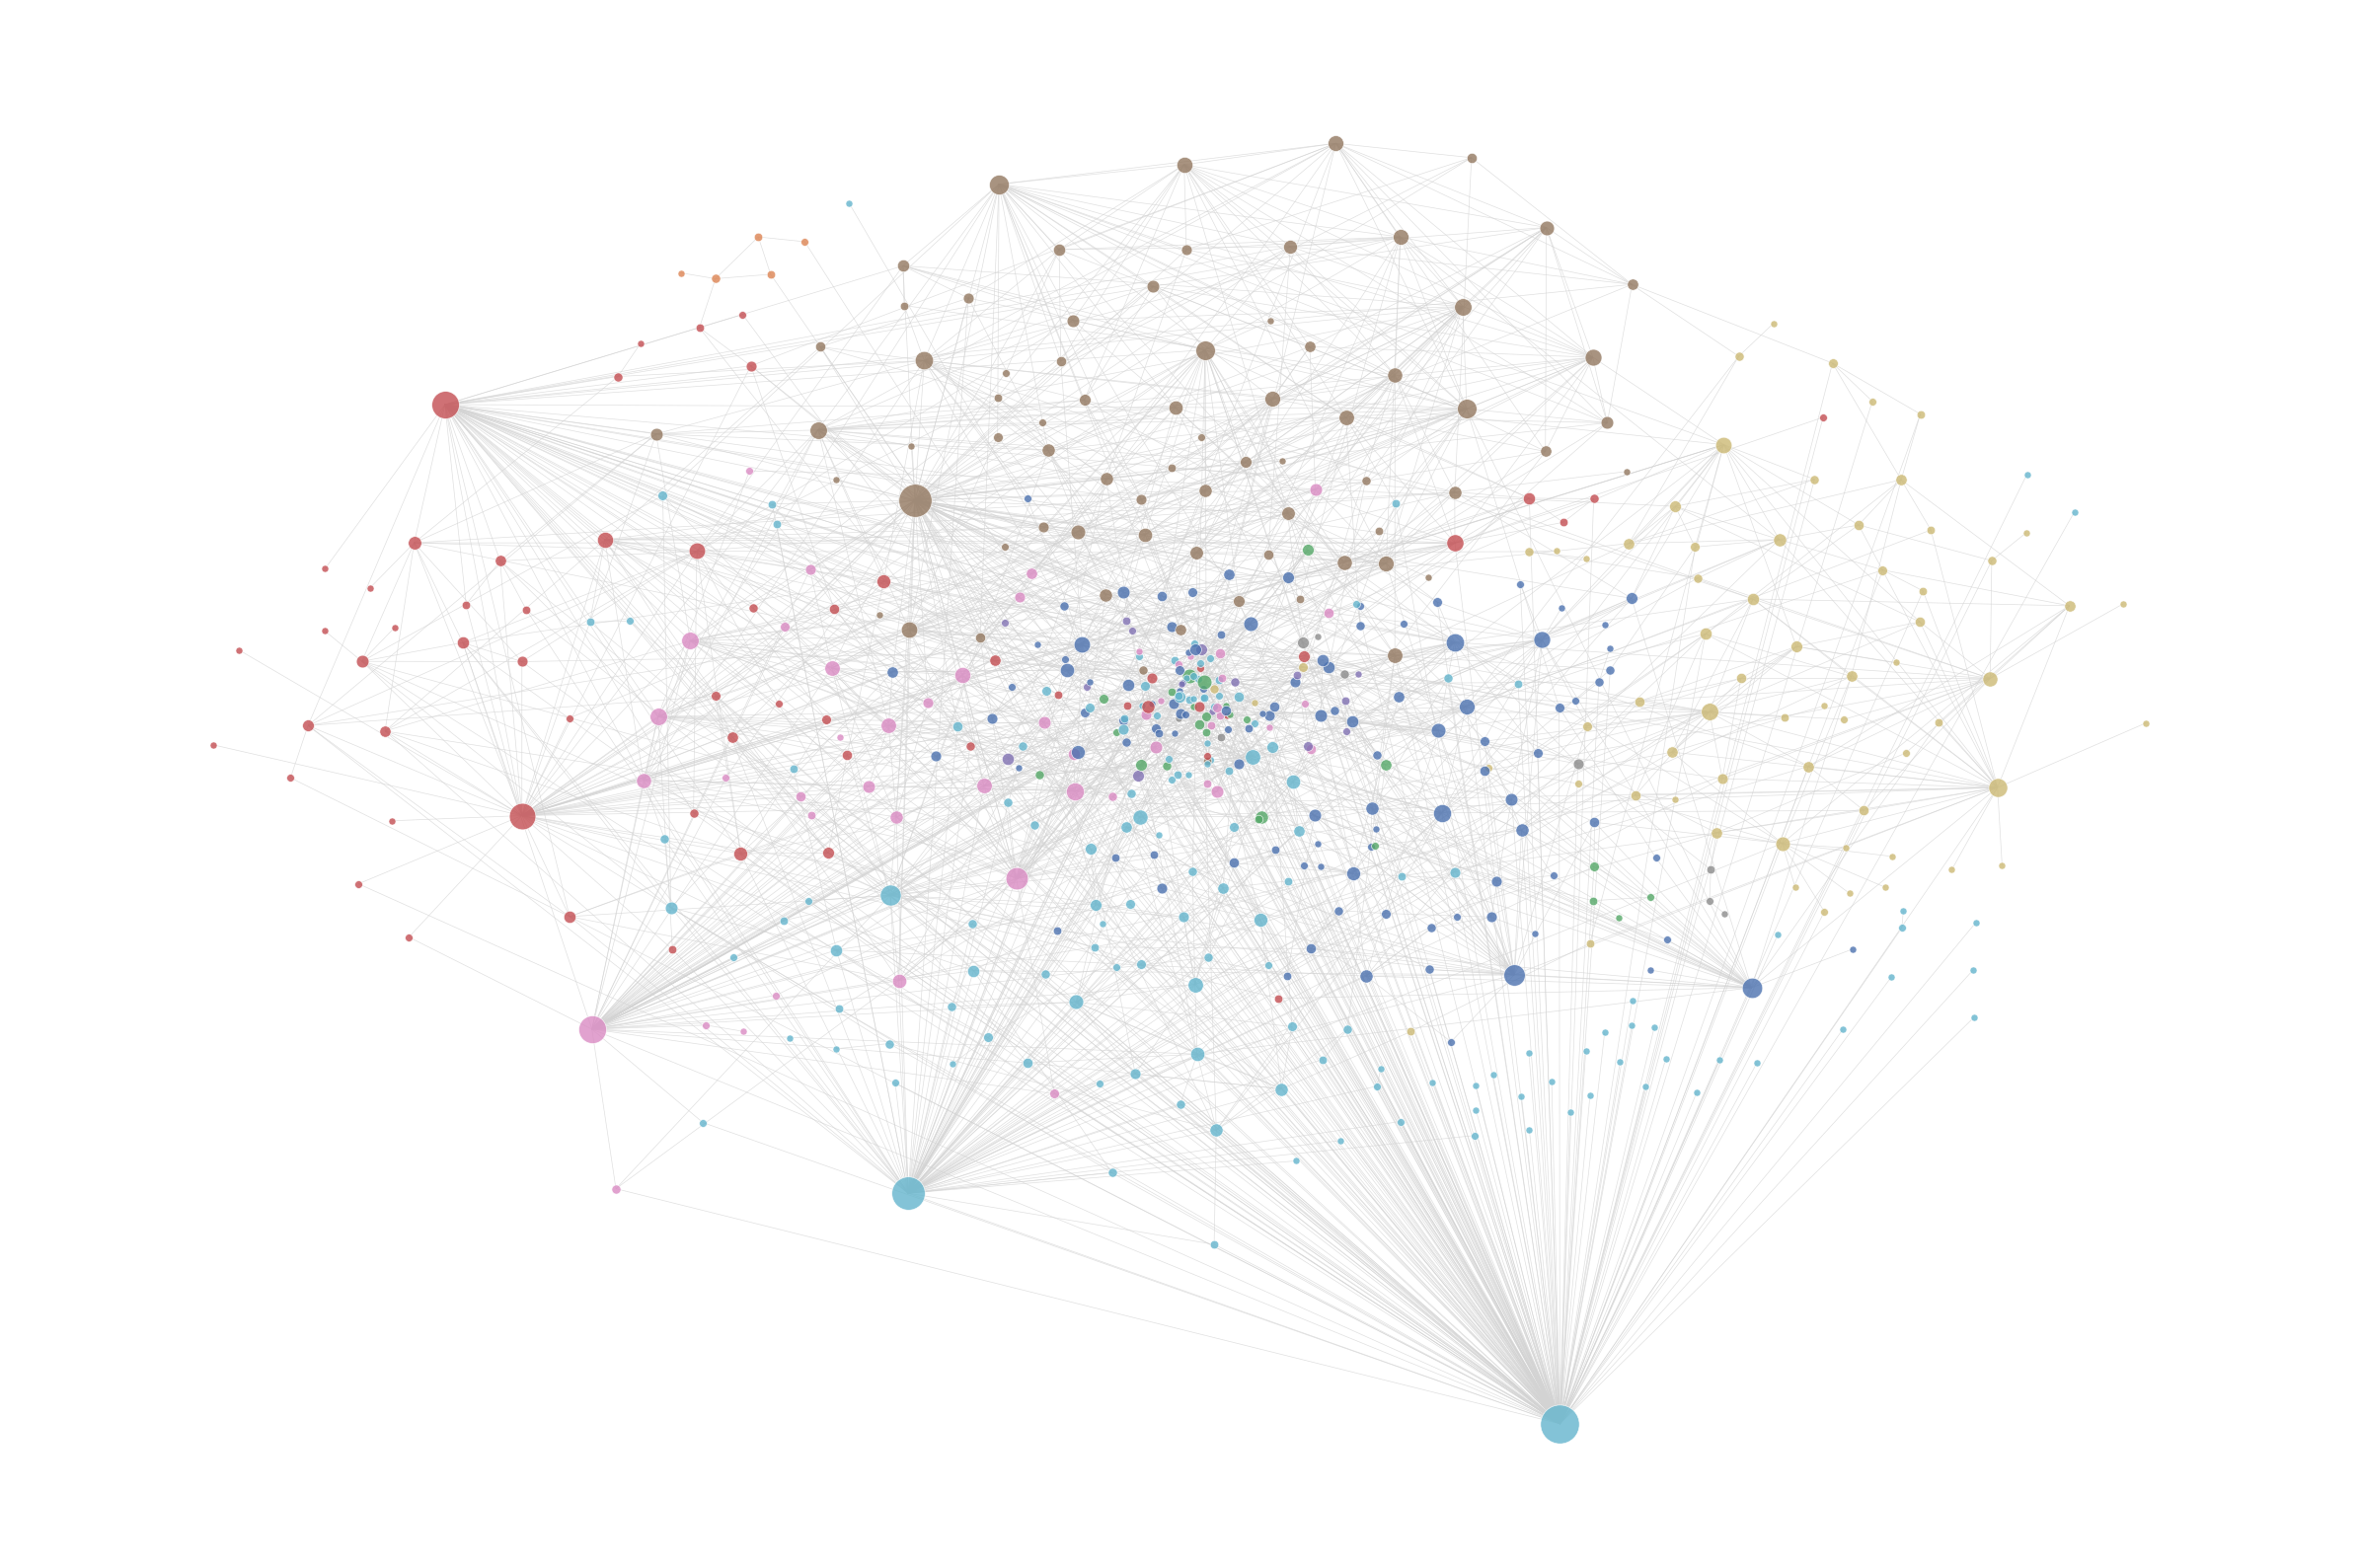

Number of communities: 11
Largest community size: 146
Smallest community size: 5
Total nodes in connected components: 554


In [356]:
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
import seaborn as sns
from fa2_modified import ForceAtlas2
import numpy as np

# Assume 'graph' is your existing graph structure
G = nx.Graph()

# Add nodes and edges
for node in graph['nodes']:
    G.add_node(node['id'], name=node['name'])
for link in graph['links']:
    G.add_edge(link['source'], link['target'])

# Remove isolated nodes
G.remove_nodes_from(list(nx.isolates(G)))

# Detect communities
partition = community_louvain.best_partition(G)

# Count nodes in each community
community_sizes = {}
for node, community in partition.items():
    if community not in community_sizes:
        community_sizes[community] = 0
    community_sizes[community] += 1

small_communities = [comm for comm, size in community_sizes.items() if size < 5]

nodes_to_remove = [node for node, comm in partition.items() if comm in small_communities]
G.remove_nodes_from(nodes_to_remove)

partition = community_louvain.best_partition(G)

forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,
    scalingRatio=5,
    strongGravityMode=False,
    gravity=200,
    verbose=True
)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=10000)

plt.figure(figsize=(24, 16), facecolor='white')
nx.draw_networkx_edges(G, positions, alpha=0.7, edge_color='lightgray', width=0.5)

degrees = dict(G.degree())
max_degree = max(degrees.values())
node_sizes = [min(20 + ((v / max_degree) * 0.8) * 1500, 800) for v in degrees.values()]
print(sorted(node_sizes, reverse=True))

unique_communities = sorted(set(partition.values()))
num_communities = len(unique_communities)
palette = sns.color_palette("deep", n_colors=num_communities)
color_map = dict(zip(unique_communities, palette))

for node, community in partition.items():
    nx.draw_networkx_nodes(G, positions, 
                           nodelist=[node],
                           node_size=node_sizes[list(G.nodes()).index(node)],
                           node_color=[color_map[community]],
                           alpha=0.8,
                           edgecolors='white',
                           linewidths=0.5)

plt.axis('off')
plt.tight_layout()

# Remove legend
plt.gca().legend_ = None

plt.show()

# Print updated community statistics
community_sizes = {}
for community in set(partition.values()):
    size = list(partition.values()).count(community)
    community_sizes[community] = size
print("Number of communities:", len(community_sizes))
print("Largest community size:", max(community_sizes.values()))
print("Smallest community size:", min(community_sizes.values()))
print("Total nodes in connected components:", len(G.nodes()))